<h1 align="center"> Final Project - Deep Learning for Computer Vision (COMS 4995)</h1>
<h2 align="center"> Automatic Image Colorization with CNNs </h2>
<h3 align="center"> Ching-Hui Hsu (UNI: ch3230), Aditya Narayanamoorthy (UNI: an2753) </h3>

# 1. Abstract

In this project, we address the problem of adding colors to gray-scle images across a wide range of classes - both containing simple scene-level background classes (like sky, mountains etc.), and complex scenes with multiple foreground objects (like people and animals). We propose a convolutional-neural-network-based system that colorizes black and white photographic images without human assistance. Two pre-trained neural nets, VGG16 and ResNet50, are used as feature extractors. We then developed a residual-style encoder that output 2 color chaneels for the input image. Moreover, we experiment on adding semantic feature learning from a Fully Convolutional Neural Network (FCN) for successfully do colorization in complex images with foreground objects.    

    
    


# 2. Framework

**Goal**: provide plausible colorizaion with saturate colors across various image without limitation on certain classes.

Our model’s framework consists of two main parts: Feature Extractor and Residual Decoder.
<li style = "font-size:18px"> <b>Feature Extractor - </b> <span style = "font-size:14px">For the task of colorization, the netowrk requires low-level and semantic representations to decide the colors for the pixel. We accomplish the global feature extraction by first using models pre-trained for classification; second, using model pre-trained for segmentation. In CNN classification models, more information can be extracted than just a final classification. Intermediate layers in these models can provide useful information. We experimented on extracting features from two pre-trained net (VGG16 [1], ResNet50 [2]) by forwarding a grayscale image through the network and then extracting four intermediate results from each of them, as shown in the dash line in Figure 1. Moreover, in order to perform better colorization and produce more saturate colors, we also generate features from the fully convolutional networks (FCNs) [7]. FCN was trained with a per-pixel multinomial logistic loss, so is expected to provide us more detail semantics. We took the features at layer _fc7_, which is the layer before doing deconvolution, as shown in Figure 2.
</span>
</li>

</br>   
</br>         
<div align="center">
<figure>
    <figcaption><b>Figure 1 - Pre-trained classification model for feature extraction.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/pre-trained-architech.png" width="750">
</figure>      
</div>

</br>   
</br>   

<div align="center">
<figure>
    <figcaption><b>Figure 2 - Pre-trained segmentation model for feature extraction.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/segnet-archi.png" width="750">
</figure>
</div>

</br>   
</br>         
   
<li style = "font-size:18px"> <b>Residual Decoder - </b> <span style = "font-size:14px"> The extracted per-pixel descriptors constitute the hypercolumns [3]. Gustav Larsson et al. construct this hypercolumn by concatenating the features at its spatial location in all layers, from data to conv7 in VGG [4]. In this work, in order to fit image batches in memory during training, we instead use a residual-encoding framework to combine these features. The connections link downstream network with upstream network. This idea is inspired in part by Ryan Dahl [5]. The residal connections are inspired by ResNet system built by He et al.

   
For decoding the features into CbCr channels, the model progressively upscale the feature tensors. It starts from taking the FCN feature (fc7) as input. Then, enter feature extracted from the highest layer of either VGG or ResNet (position "(4)" at Figure 1), do up-sampling and convolution and add-in information from the next highest layer (position "(3)" at Figure 1), and so on. At the end, use a sigmoid transfer function to restrict the output values between 0 and 1. The loss is computed by Euclidean distance between the predicted CbCr output and the reference image. The decoder model is plot in Figure 3. The final overall architecture is shown in Figure 4.
</span>
</li>
</br>   
</br>

<div align="center">
<figure>
    <figcaption><b>Figure 3 - Residual decoder.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/color_model_seg.png" width = "850">
</figure>
</div>

</br>   
</br>   

<div align="center">
<figure>
    <figcaption><b>Figure 4 - Overall architecture.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/final-archi.png" width="750">
</figure>
</div>

</br>   
</br>      
   

# 3. Experiments and Results

We conducted experiments on two datasets. One is the MIT Open Country dataset, which contains 411 natural images of scenery, sea, mountain. We first train on this dataset for global information. During training, we observe that the low-level features, such as sky, grass are painted in the earlier epochs. The second dataset we adopted is PASCAL 2011, which contains many complex foreground objects. Only the first 2000 images are used for this experiment to make the training faster. These images are stripped of color data to provide input images. The ground truth is the full color image converted to YCbCr color space.

Since VGG16/ResNet50 have many layers from which features can be extracted, using feautres from all of the layers is not only computationally expensive but also suffers from lots of redundant information across layers. We adopt a subset of layers by choosing the last layer from each block as defined in the original VGG/ResNet papers. We also use the last encoding layer from FCN. In together, they represented both low-level and high-level information.

Different regression-based loss functions such as euclidean loss (L2 loss) and abs loss were test to run for few epochs and found no obvious different in terms of performance/speed, so we stick with L2 loss, as in the work from Cheng el al. [6].   

We use Keras wrapper with tensorflow backend for our project. Since there's no existing Tensorflow model for FCN. We implement the function to convert the FCN model from Caffe to Tensorflow. The detail is written in another notebook: Appendix-FCN Segmentation_Conversion.ipynb. Rmsprop is used for updating the parameters. Batch-size is 8 on AWS GPU g2.2xlarge instance. The training of the full network is divided into three steps: (1) Learn global information from open country dataset. We found the loss rarely decrease after 200 epochs. (2) Starting from previous learnt weights,  learn foreground object information from PASCAL dataset. (3) Add-in semantic features from FCN.

We found that the ResNet model converge more slowly than the VGGNet model, but the model's outputs have more colors and produced more saturate images. We choose to add FCN features only in the VGG model (VGG+FCN) as our final model because of faster convergence. From Figure 5, We can visually tell from the skin and the red cloth that the VGG+FCN produce even more colorful images than the ResNet. Table 1 provides benchmarks for the three modelse by using root mean square error (RMSE) in CbCr averaged over all pixels. Although the RMSE in VGG+FCN is higher, it is because of the time constraint, VGG+FCN model is only trained for ~50 epochs, which is much less than pure VGG models (~250 epochs). Also, the training loss of VGG+FCN is still continuously decrease (Figure 6a). Thus, we conclude that with longer training time, this VGG+FCN model is promising for given the best result.  

</br>   
</br>      
        
<div align="center">
<figure>
    <figcaption><b>Figure 5 - Output on different models.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/result-combine-1.png" width = "850">
</figure>
</div>

</br>   
</br> 

<div align="center"><b>Table 1. Models Comparison by RMSE.</b></div>
       
|   VGG  | ResNet | VGG+FCN |
|:------:|:------:|:-------:|
| 0.0423 | 0.0546 |  0.0484 |
 
</br>   
</br> 

<div align="center">
<figure>
    <figcaption><b>Figure 6 - Training loss on the Open Country + PASCAL datasets for (a) VGG model. (b) VGG+FCN model.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/loss-combined.png" width = "850">
</figure>
</div>

</br>   
</br>    


For comparison with leading method, we refer to the images published on [4]. They use the SUN-6 dataset, which is a complete different data from our training set. SUN-6 includes images from 6 scene categories. Many colorization works are focused on a dataset (e.g. SUN-6) limited to images of a few scene classes, and best results are obtained when the scene class is known at test time. We compare our result to those in [4], [8] and [9]. Figure 7 shows a comparison of results on SUN-6. Works from [8] and [9] use GT Scene (test image scene class is available) and GT Hist (test image color histogram is available). Although there are some pixels shown with unexpected sharp colors due to yet converging training, our fully automatic system produces output qualitatively superior to methods relying on such side information.

</br>   
</br> 

<div align="center">
<figure>
    <figcaption><b>Figure 7 - Visualize comparison with leading methods on SUN-6.</b></figcaption>
    <img src="https://raw.githubusercontent.com/CHJoanna/Image-Color-Net/master/imgs-archi/compare-to-others.png" width = "850">
</figure>
</div>

</br>   
</br>    



# 4. Conclusion and Future Work

**Conclusion**   
We have demonstrated the potential of using various pre-trained deep networks to colorize black and white images. In particular, we have empirically shown that combing global and semantic information can yield more colorful images that are more aesthetically-pleasing. We obtain colorizations with visual quality slightly better than those from prior work, even though we do not exploit reference images or known scene class.

</br>   

**Future work**   
(1) Use features from more layers is expected to improve the colorization performance. Do experiment for balancing the trade-off between accuracy and computation-ability.    
(2) As some works has mentioned, although regression does seem to be well-suited to the task due to the continuous nature of color spaces, in practice, it would tend to generate images that are desaturated in color tonality. A classification-based loss function may work better.   
(3) As VGG and ResNet are pre-trained for colored images, many neurons are sensitive to the color. Do transfer learning for grayscale images before feature extraction might give us more robust features. 
(4) Do style transfer via global features. Adapt the colorization of one image to the style of another.


# References
[1] K. Simonyan and A. Zisserman, Very Deep Convolutional Networks for Large-Scale Image Recognition, ICLR (2014)   
[2] K. He, X. Zhang, S. Ren and J. Sun, Deep Residual Learning for Image Recognition, CVPR (2016)   
[3] B. Hariharan, P. Arbeláez, R. Girshick and J. Malik, Hypercolumns for Object Segmentation and Fine-grained Localization, CVPR (2015)   
[4] G. Larsson, M. Maire, and G. Shakhnarovich, Learning Representations for Automatic Colorization, ECCV (2016)   
[5] R. Dahl, http://tinyclouds.org/colorize/   
[6] Z. Cheng, Q. Yang and B. Sheng, Deep Colorization, ICCV (2015)   
[7] J. Long∗, E. Shelhamer∗ and T. Darrell, Fully Convolutional Networks for Semantic Segmentation, CVPR (2015)   
[8] T. Welsh, M. Ashikhmin and K. Mueller, Transferring color to greyscale images, ACM Transactions on Graphics (TOG) (2002)   
[9] A. Deshpande, J. Rock and D. Forsyth, Learning large-scale automatic image colorization, ICCV (2015)


# Appendix 
Appendix-FCN Segmentation_Conversion.ipynb

</br>      
</br>   
</br>   
<h1 align="center"> Detail Implementation </h1>

### Import Libraries

In [1]:
import cv2

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

import os
import h5py
import fnmatch

from keras import backend, optimizers
from keras.layers import MaxPooling2D, ZeroPadding2D, UpSampling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras.layers import add
from keras.layers import Input

from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import load_model
from keras import applications
from keras.models import Model


from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline


Using TensorFlow backend.


### Load data images - Preprocess data to YCbCr
Dataset(1) - MIT CVCL Open Country (http://cvcl.mit.edu/database.htm)   
Dataset(2) - PASCAL 2011 (http://host.robots.ox.ac.uk/pascal/VOC/)

In [23]:
img_path = 'data/OpenCountry/'
            
def load_image_oc():
    X_train = [] 
    Y_train = []
    for root, dirnames, filenames in os.walk(img_path):
        for filename in fnmatch.filter(filenames, '*.jpg'):
            img = image.load_img(os.path.join(img_path, filename), target_size=(224, 224))
            pil_array = image.img_to_array(img)
            Gray = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2GRAY)
            YCbRr = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2YCR_CB)
            
            Gray = np.dstack([Gray, Gray, Gray])

            X_train.append(Gray)
            Y_train.append(YCbRr)
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    print "X_train, Y_train loaded"
    print "X: ", X_train.shape
    print "Y: ", Y_train.shape
    return X_train, Y_train

X_train, Y_train = load_image_oc()

X_train, Y_train loaded
X:  (410, 224, 224, 3)
Y:  (410, 224, 224, 3)


In [2]:
img_path = 'data/Pascal2011/JPEGImages/'

def load_image_pascal():
    X_train = [] 
    Y_train = []
    i = 0
    for root, dirnames, filenames in os.walk(img_path):
        for filename in fnmatch.filter(filenames, '*.jpg'):
            img = image.load_img(os.path.join(img_path, filename), target_size=(224, 224))
            pil_array = image.img_to_array(img)
            Gray = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2GRAY)
            YCbRr = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2YCR_CB)
            
            Gray = np.dstack([Gray, Gray, Gray])

            X_train.append(Gray)
            Y_train.append(YCbRr)
            i += 1
            if i >= 2000: break
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    print "X_train, Y_train loaded"
    print "X: ", X_train.shape
    print "Y: ", Y_train.shape
    return X_train, Y_train

X_train, Y_train = load_image_pascal()

X_train, Y_train loaded
X:  (2000, 224, 224, 3)
Y:  (2000, 224, 224, 3)


### Load pre-trained VGG16 model

In [17]:
# build the VGG16 network
vgg_model = applications.VGG16(include_top=False, weights='imagenet')
graph = tf.get_default_graph()

# trained model files
color_weights_path = '../color_45-10.60.hdf5'
seg_model_path = '../models-seg/seg_model.h5'

seg_model = load_model(seg_model_path)

/Users/joanna/.virtualenvs/keras_tf/lib/python2.7/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Define model for features extracted from VGG net

In [6]:
def convert_to_tensor(layer_name):
    """
    convert extracted intermediate layer(numpy array) to "Input" tensor
    """
    input_shape = tensors[layer_name].shape
    temp =  backend.variable(value = tensors[layer_name])
    temp = BatchNormalization(axis=3, name='bn_input')(temp)
    input_layer = Input(tensor = temp, shape=input_shape, name = 'input_' + layer_name)
    return input_layer

def res_vgg_colornet(X_train = None):
    
    if X_train is None:
        # Features from intermediate layers of VGG-16 network
        x1 = Input(shape=(28,28,512))
        x2 = Input(shape=(56,56,256))
        x3 = Input(shape=(112,112,128))
        x4 = Input(shape=(224,224,64))

        # Additional features coming from the segmentation model
        s1 = Input(shape=(7, 7, 4096))
        # Original image input
        input_layer = Input(shape=(224,224,3))

    # Bx7x7x4096 -> 1x1 convolution = Bx7x7x512
    conv_s = Conv2D(512, (1, 1), activation='relu', name = 'conv_s')(s1)
    # Upscale to 28x28x512
    conv_s = UpSampling2D((4, 4), name = 'upsample_s')(conv_s)
    
    # Add to x1
    print(conv_s)
    conv_s = add([conv_s, x1], name = 'add_s')
    conv_s = BatchNormalization(axis=3, name = 'bn_conv_s')(conv_s)        
        
        
    # Bx28x28x512 -> 1x1 conv = Bx28x28x256
    conv1 = Conv2D(256, (1, 1), activation = 'relu', name = 'conv1')(conv_s)
    # upscale to 56x56x256
    conv1 = UpSampling2D((2, 2), name = 'upsample1')(conv1)

    print conv1
    conv1 = add([conv1, x2], name = 'add1')
    conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1)

    # Bx56x56x256-> 3x3 conv = Bx56x56x128
    conv2 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', name = 'conv2')(conv1)
    # upscale to 112x112x128
    conv2 = UpSampling2D((2, 2), name = 'upsample2')(conv2)

    print conv2
    conv2 = add([conv2, x3], name = 'add2')
    conv2 = BatchNormalization(axis=3, name='bn_conv2')(conv2)

    # Bx112x112x128 -> 3x3 conv = Bx112x112x64
    conv3 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', name = 'conv3')(conv2)
    # upscale to 224x224x64
    conv3 = UpSampling2D((2, 2), name = 'upsample3')(conv3)

    print conv3
    conv3 = add([conv3, x4], name = 'add3')
    conv3 = BatchNormalization(axis=3, name='bn_conv3')(conv3)

    # Bx224x224x64 -> 3x3 conv = Bx224x224x3
    conv4 = Conv2D(3, (3, 3), padding = 'same', activation = 'relu', name = 'conv4')(conv3)

    conv4 = add([conv4, input_layer], name = 'add4')
    conv4 = BatchNormalization(axis=3, name='bn_conv4')(conv4)

    # Bx224x224x3 -> 3x3 conv = Bx224x224x3
    conv5 = Conv2D(3, (3, 3), padding = 'same', activation = 'relu', name ='conv5')(conv4)

    conv5 = BatchNormalization(axis=3, name='bn_conv5')(conv5)

    # Bx224x224x3 -> 3x3 conv = Bx224x224x2
    conv6 = Conv2D(2, (3, 3), padding ='same', activation='sigmoid', name='conv6')(conv5)
    print conv6

    model = Model(inputs=[x1, x2, x3, x4, s1, input_layer], outputs=[conv6])
    return model
    

### Load pre-trained ResNet50 model

In [19]:
from keras import applications
from keras.applications.resnet50 import ResNet50
# build the ResNet network
resnet_model = ResNet50(include_top=False,weights='imagenet')
# graph = tf.get_default_graph()
# resnet_model.summary()

### Define model for features extracted from ResNet

In [15]:
def res_res_colornet(X_train = None):

    if X_train is None:
        x1 = Input(shape=(14,14,1024))
        x2 = Input(shape=(28,28,512))
        x3 = Input(shape=(55,55,256))
        x4 = Input(shape=(112,112,64))
        input_layer = Input(shape=(224,224,3))
            
    # Bx14x14x1024 -> 1x1 conv = Bx14x14x512
    conv1 = Conv2D(512, (1, 1), activation = 'relu', name = 'conv1')(x1)
    # upscale to 28x28x512
    conv1 = UpSampling2D((2, 2), name = 'upsample1')(conv1)

    print conv1
    conv1 = add([conv1, x2], name = 'add1')
    conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1)

    # Bx28x28x512-> 3x3 conv = Bx28x28x256
    conv2 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv2')(conv1)
    # upscale to 56x56x256
    conv2 = UpSampling2D((2, 2), name = 'upsample2')(conv2)

    print conv2
    #pad x3
    temp3 = ZeroPadding2D(((0, 1), (0, 1)))(x3)
    conv2 = add([conv2, temp3], name = 'add2')
    conv2 = BatchNormalization(axis=3, name='bn_conv2')(conv2)

    # Bx56x56x256 -> 3x3 conv = Bx56x56x64
    conv3 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', name = 'conv3')(conv2)
    # upscale to 112x112x64
    conv3 = UpSampling2D((2, 2), name = 'upsample3')(conv3)

    print conv3
    conv3 = add([conv3, x4], name = 'add3')
    conv3 = BatchNormalization(axis=3, name='bn_conv3')(conv3)

    # Bx112x112x64 -> 3x3 conv = Bx112x112x3
    conv4 = Conv2D(3, (3, 3), padding = 'same', activation = 'relu', name = 'conv4')(conv3)
    # upscale to 224x224x3
    conv4 = UpSampling2D((2, 2), name = 'upsample4')(conv4)

    conv4 = add([conv4, input_layer], name = 'add4')
    conv4 = BatchNormalization(axis=3, name='bn_conv4')(conv4)

    # Bx224x224x3 -> 3x3 conv = Bx224x224x3
    conv5 = Conv2D(3, (3, 3), padding = 'same', activation = 'relu', name ='conv5')(conv4)

    conv5 = BatchNormalization(axis=3, name='bn_conv5')(conv5)

    # Bx224x224x3 -> 3x3 conv = Bx224x224x2
    conv6 = Conv2D(2, (3, 3), padding ='same', activation='sigmoid', name='conv6')(conv5)
    print conv6

    model = Model(inputs=[x1, x2, x3, x4, input_layer], outputs=[conv6])
    return model
    

### Compile Keras model

In [18]:
color_model = res_vgg_colornet()
plot_model(color_model, to_file='model.png', show_layer_names=False, show_shapes=False)

Tensor("upsample_s_2/ResizeNearestNeighbor:0", shape=(?, 28, 28, 512), dtype=float32)
Tensor("upsample1_2/ResizeNearestNeighbor:0", shape=(?, 56, 56, 256), dtype=float32)
Tensor("upsample2_2/ResizeNearestNeighbor:0", shape=(?, 112, 112, 128), dtype=float32)
Tensor("upsample3_2/ResizeNearestNeighbor:0", shape=(?, 224, 224, 64), dtype=float32)
Tensor("conv6_2/Sigmoid:0", shape=(?, 224, 224, 2), dtype=float32)


### Euclidiance loss function

In [11]:
def euclidean_distance_1(y_true, y_pred):
    square_ = backend.square(y_true - y_pred)
    sum_ = backend.sum(square_, axis = 1)
    sum_ = backend.sum(sum_, axis = 1)
    mean_ = backend.mean(sum_)
    sqrt_ = backend.sqrt(mean_)
    return sqrt_


In [9]:
color_model.compile(optimizer='rmsprop', loss = euclidean_distance_1)
print(color_model.summary())

tensorboard_callback = TensorBoard(log_dir='./logs1-1/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models1-1/{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=0, save_best_only=True)

### Make a generator to get intermediate feature 

In [15]:
def gen_intermediate_feature(input_data):
    listOfInterest_conv = [2, 5, 9, 13]
    segmentation_conv = 33
    tensors = {}
    for i in listOfInterest_conv:
        # build a Keras function that will return the output of a certain layer given a certain input
        intermediate_output = backend.function([vgg_model.layers[0].input], [vgg_model.layers[i].output])
        output_image = intermediate_output([input_data])
        tensors[vgg_model.layers[i].get_config()['name']] = output_image[0]
        
        
    # Add the tensor from the segmentation model as well
    # NOTE: Since the segmentation network contains a Dropout layer, code needs to be added to specify test mode
    intermediate_output = backend.function([seg_model.layers[0].input, backend.learning_phase()], 
                                           [seg_model.layers[segmentation_conv].output])
    
    output_image = intermediate_output([input_data, 0])
    tensors[seg_model.layers[segmentation_conv].get_config()['name']] = output_image[0]
    return tensors


## feature generator
def generate_feature_from_train(num_samples, batch_size):
    global graph
    with graph.as_default():
        start = 0
        while True:
            index = np.arange(num_samples)
            np.random.shuffle(index)
            batch = index[start:start+batch_size]                  
            feature_tensor = gen_intermediate_feature(X_train[batch])
            # Also get the features from the segnet
            yield [feature_tensor['block4_conv3'], feature_tensor['block3_conv3'], \
                   feature_tensor['block2_conv2'], feature_tensor['block1_conv2'], \
                   feature_tensor['fc7'], X_train[batch]], \
            [np.concatenate((Y_train[batch,:,:,1,None],Y_train[batch,:,:,2,None]), axis =3)]
            start += batch_size
            if start >= num_samples:
                start = 0            

### Start training 

Start a new training with batch size = 8 (The history output at below cell is training from scrach, which is STEP 1 in our experiment.)

In [10]:
num_samples = 400
batch_size = 8
history = color_model.fit_generator(generate_feature_from_train(num_samples, batch_size),
                                    steps_per_epoch = num_samples / batch_size, epochs = 200, verbose = 1,
                                    callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/200
50/50 [==============================] - 78s - loss: 18.5117    
Epoch 2/200
50/50 [==============================] - 67s - loss: 15.2007    
Epoch 3/200
50/50 [==============================] - 69s - loss: 14.7286    
Epoch 4/200
50/50 [==============================] - 69s - loss: 15.1577    
Epoch 5/200
50/50 [==============================] - 71s - loss: 13.9078    
Epoch 6/200
50/50 [==============================] - 72s - loss: 14.4922    
Epoch 7/200
50/50 [==============================] - 73s - loss: 14.0514    
Epoch 8/200
50/50 [==============================] - 73s - loss: 14.0609    
Epoch 9/200
50/50 [==============================] - 75s - loss: 13.7471    
Epoch 10/200
50/50 [==============================] - 75s - loss: 13.6852    
Epoch 11/200
50/50 [==============================] - 75s - loss: 13.4430    
Epoch 12/200
50/50 [==============================] - 76s - loss: 13.4325    
Epoch 13/200
50/50 [==============================] - 75s - loss: 13.4553

Exception IndexError: IndexError('list index out of range',) in <generator object generate_feature_from_train at 0x7ff7c9b42c30> ignored


Resume training from previous trained models

In [11]:
num_samples = 400
batch_size = 8
history = color_model.fit_generator(generate_feature_from_train(num_samples, batch_size),
                                    steps_per_epoch = num_samples / batch_size, epochs = 500, verbose = 1,
                                    callbacks = [tensorboard_callback, checkpoint_callback],
                                   initial_epoch = 200)

Epoch 201/500
50/50 [==============================] - 237s - loss: 8.3448   
Epoch 202/500
50/50 [==============================] - 236s - loss: 8.3511   
Epoch 203/500
50/50 [==============================] - 236s - loss: 8.2812   
Epoch 204/500
50/50 [==============================] - 236s - loss: 8.4395   
Epoch 205/500
50/50 [==============================] - 238s - loss: 8.6299   
Epoch 206/500
50/50 [==============================] - 239s - loss: 8.3593   
Epoch 207/500
50/50 [==============================] - 239s - loss: 8.2331   
Epoch 208/500
50/50 [==============================] - 239s - loss: 8.6455   
Epoch 209/500
50/50 [==============================] - 240s - loss: 8.2578   
Epoch 210/500
50/50 [==============================] - 241s - loss: 8.2868   
Epoch 211/500
50/50 [==============================] - 242s - loss: 8.4663   
Epoch 212/500
50/50 [==============================] - 241s - loss: 8.1348   
Epoch 213/500
50/50 [==============================] - 242s - lo

KeyboardInterrupt: 

### Evaluation

In [3]:
def predict_img(X_test_small):
    val_feature = gen_intermediate_feature(X_test_small)
    predict_img = color_model.predict([val_feature['block4_conv3'], val_feature['block3_conv3'],
                                       val_feature['block2_conv2'], val_feature['block1_conv2'], 
                                       val_feature['fc7'], X_test_small])
    print predict_img.shape
    return predict_img

def plot_img(predict_img, ycbcr_img, gray_img):
    num_img = ycbcr_img.shape[0]
    for i in range(num_img):
        fig = plt.figure(figsize=(8,8))
        predict_ycbcr = np.dstack([ycbcr_img[i][:,:,0], predict_img[i].squeeze()[:,:,0], predict_img[i].squeeze()[:,:,1]])
        ax = fig.add_subplot(1,3,1)
        ax.imshow(gray_img[i].squeeze())
        plt.xticks([])
        plt.yticks([]) 
        
        ax = fig.add_subplot(1,3,2)
        ax.imshow(cv2.cvtColor(predict_ycbcr ,cv2.COLOR_YCR_CB2BGR))
        plt.xticks([])
        plt.yticks([]) 
        
        ax = fig.add_subplot(1,3,3)
        ax.imshow(cv2.cvtColor(ycbcr_img[i], cv2.COLOR_YCR_CB2BGR))
        plt.xticks([])
        plt.yticks([]) 
        plt.tight_layout()

### Define another function for the ResNet model

In [4]:
def gen_intermediate_feature_resnet(input_data):
    listOfInterest_conv = [4, 37, 79, 141]
    tensors = {}
    for i in listOfInterest_conv:
        # build a Keras function that will return the output of a certain layer given a certain input
        inter_model = Model(inputs=resnet_model.input, outputs=resnet_model.layers[i].output)
        intermediate_output = inter_model.predict(input_data)
        
        tensors[i] = intermediate_output
    return tensors

def load_indiv_images(file_list):
    X_eval = [] 
    Y_eval = []
    for filename in file_list:
        img = image.load_img(os.path.join(img_path, filename), target_size=(224, 224))
        pil_array = image.img_to_array(img)
        Gray = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2GRAY)
        YCbRr = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2YCR_CB)

        Gray = np.dstack([Gray, Gray, Gray])

        X_eval.append(Gray)
        Y_eval.append(YCbRr)
    
    return X_eval, Y_eval

def predict_img_all_models(X_test_small, color_model, color_resnet_model, color_seg_model):
    val_feature = gen_intermediate_feature(X_test_small)
    val_feature_resnet = gen_intermediate_feature_resnet(X_test_small)
    color_predict_img = color_model.predict([val_feature['block4_conv3'], val_feature['block3_conv3'],
                                       val_feature['block2_conv2'], val_feature['block1_conv2'], X_test_small])
    
    resnet_predict_img = color_resnet_model.predict([val_feature_resnet[141], val_feature_resnet[79],
                                       val_feature_resnet[37], val_feature_resnet[4], X_test_small])
    seg_predict_img = color_seg_model.predict([val_feature['block4_conv3'], val_feature['block3_conv3'],
                                       val_feature['block2_conv2'], val_feature['block1_conv2'], val_feature['fc7'], 
                                       X_test_small])
    return color_predict_img, resnet_predict_img, seg_predict_img

def plot_img_all_models(predict_img_list, ycbcr_img, gray_img):
    num_img = ycbcr_img.shape[0]
    num_models = len(predict_img_list)
    
    for i in range(num_img):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,2 + num_models,1)
        ax.imshow(gray_img[i].squeeze())
        plt.xticks([])
        plt.yticks([]) 
        
        for j in range(num_models):
            predict_img = predict_img_list[j]
            predict_ycbcr = np.dstack([ycbcr_img[i][:,:,0], predict_img[i].squeeze()[:,:,0], predict_img[i].squeeze()[:,:,1]])
            ax = fig.add_subplot(1,2 + num_models,2 + j)
            ax.imshow(cv2.cvtColor(predict_ycbcr ,cv2.COLOR_YCR_CB2BGR))
            plt.xticks([])
            plt.yticks([]) 
        
        ax = fig.add_subplot(1,2 + num_models,2 + num_models)
        ax.imshow(cv2.cvtColor(ycbcr_img[i], cv2.COLOR_YCR_CB2BGR))
        plt.xticks([])
        plt.yticks([]) 
        plt.tight_layout()

(5, 224, 224, 2)


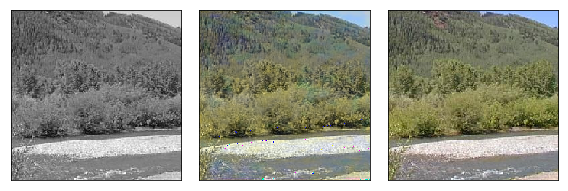

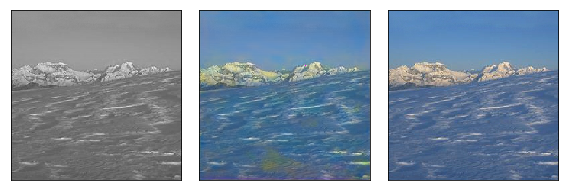

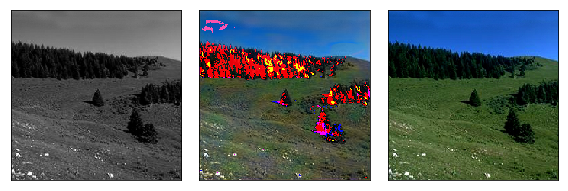

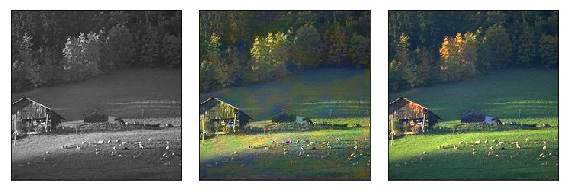

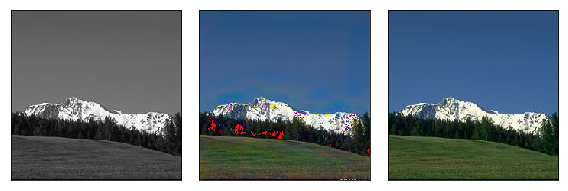

In [14]:
num_samples = 400
batch_size = 4
color_model = load_model('./models/248-7.38.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})

first = 0
eval_train_list = np.random.permutation(num_samples)[0:k]
# eval_train_list = np.arange(num_samples)[first:first+5]

X_eval = X_train[eval_train_list]
Y_eval = Y_train[eval_train_list]
predict_train_img = predict_img(X_eval)

plot_img(predict_train_img, Y_eval, X_eval)

### Start training on PASCAL dataset
We only use 2000 images from PASCAL dataset for making the training faster. (The history output at below cell is STEP 2 in our experiment.)

In [8]:
tensorboard_callback = TensorBoard(log_dir='./logs1-pascal/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models1-pascal/{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=0, save_best_only=True)

In [ ]:
num_samples = 2000
batch_size = 8
color_model = load_model('./models1-1/245-7.93.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})

history = color_model.fit_generator(generate_feature_from_train(num_samples, batch_size),
                                    steps_per_epoch = num_samples / batch_size, epochs = 200, verbose = 1,
                                    callbacks = [tensorboard_callback, checkpoint_callback],
                                   initial_epoch = 0)

Epoch 1/200
250/250 [==============================] - 371s - loss: 13.1211   
Epoch 2/200
250/250 [==============================] - 378s - loss: 12.4146   
Epoch 3/200
250/250 [==============================] - 397s - loss: 12.3561   
Epoch 4/200
250/250 [==============================] - 415s - loss: 12.2597   
Epoch 5/200
250/250 [==============================] - 432s - loss: 12.5145   
Epoch 6/200
250/250 [==============================] - 456s - loss: 12.2946   
Epoch 7/200
250/250 [==============================] - 470s - loss: 12.0640   
Epoch 8/200
250/250 [==============================] - 485s - loss: 11.9839   
Epoch 9/200
250/250 [==============================] - 501s - loss: 11.7235   
Epoch 10/200
250/250 [==============================] - 515s - loss: 12.3236   
Epoch 11/200
250/250 [==============================] - 534s - loss: 12.1535   
Epoch 12/200
250/250 [==============================] - 555s - loss: 11.9231   
Epoch 13/200
250/250 [===========================

### Evaluation after traing on PASCAL data

(5, 224, 224, 2)


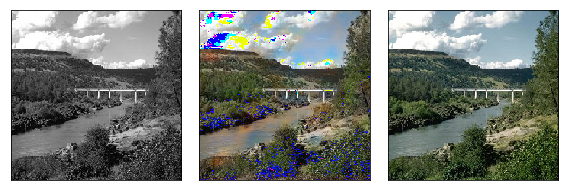

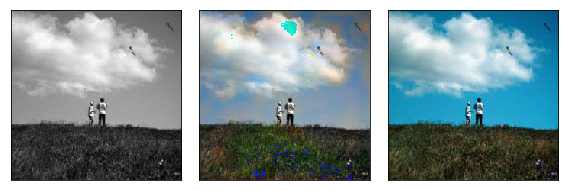

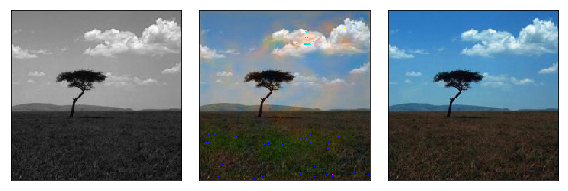

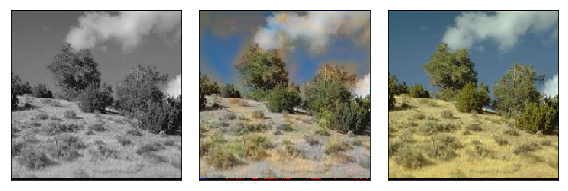

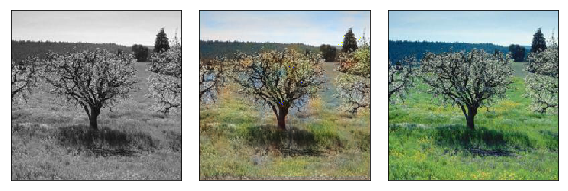

In [24]:
num_samples = 1000
color_model = load_model('./models-pascal/45-10.60.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})

first = 0

eval_train_list = np.random.permutation(num_samples)[0:k]
# eval_train_list = np.arange(num_samples)[first:first+5]

X_eval = X_train[eval_train_list]
Y_eval = Y_train[eval_train_list]
predict_train_img = predict_img(X_eval)

plot_img(predict_train_img, Y_eval, X_eval)

## Test on the full models!

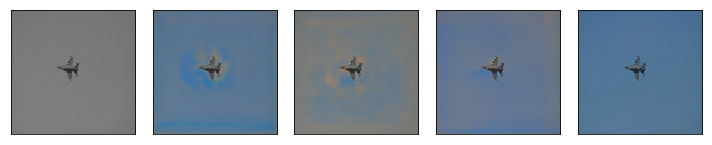

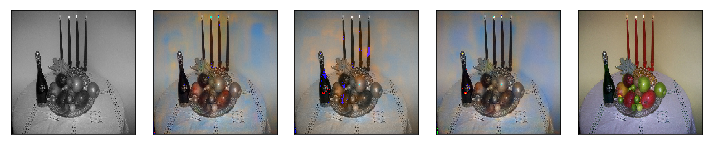

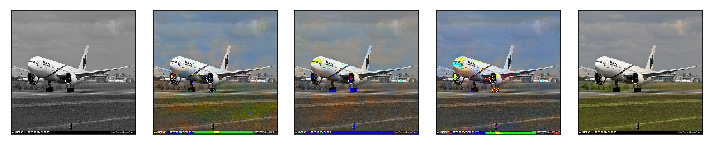

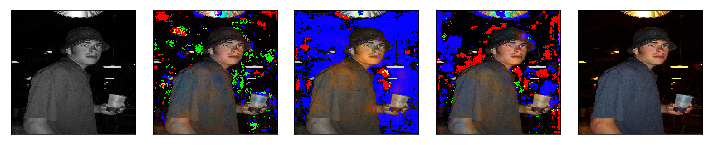

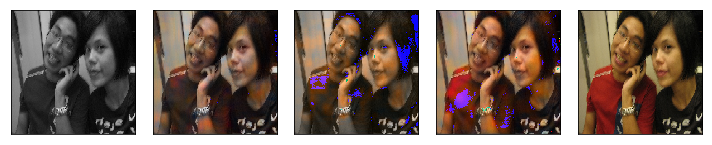

In [19]:
# Testing on certain images across all models
# Load models
color_model = load_model('./models-pascal/45-10.60.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})
color_resnet_model = load_model('./models2-pascal/res-65-10.94.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})
color_seg_model = load_model('./models-seg/57-7.93.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})

start = 0
eval_train_list = np.random.permutation(num_samples)[start : start + 5]
# eval_train_list = np.arange(num_samples)[start:start + 5]

X_eval = X_train[eval_train_list]
Y_eval = Y_train[eval_train_list]

color_predict_img, resnet_predict_img, seg_predict_img = predict_img_all_models(
    X_eval, color_model, color_resnet_model, color_seg_model)
plot_img_all_models([color_predict_img, resnet_predict_img, seg_predict_img], Y_eval, X_eval)

### Comparison between Models

In [22]:
from sklearn import metrics
# Calculate RMSE
def eval_metric(cbcr_true, cbcr_pred):
    l2 = np.square(cbcr_true - cbcr_pred)
    # Find mean over all values, take square root, return
    return np.sqrt(np.sum(l2) / l2.size)

# Find metric for the image compared to the ground truths
print "VGG model: ", (eval_metric(Y_eval[:,:,:,1:3], color_predict_img))
print "ResNet model: ", (eval_metric(Y_eval[:,:,:,1:3], resnet_predict_img))
print "VGG+FCN model: ", (eval_metric(Y_eval[:,:,:,1:3], seg_predict_img))

VGG model:  0.0422955275314
ResNet model:  0.0545763649281
VGG+FCN model:  0.0484454597327


### Comparison with leading methods on SUN-6 dataset

In [7]:
img_path = '../data/sun6/'
pic_file =[]            
def load_image_oc():
    X_train = [] 
    Y_train = []
    for root, dirnames, filenames in os.walk(img_path):
        for filename in fnmatch.filter(filenames, '*.png'):
            img = image.load_img(os.path.join(img_path, filename), target_size=(224, 224))
            pil_array = image.img_to_array(img)
            Gray = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2GRAY)
            YCbRr = cv2.cvtColor(pil_array / 255.0, cv2.COLOR_BGR2YCR_CB)
            
            Gray = np.dstack([Gray, Gray, Gray])
            pic_file.append(filename)
            X_train.append(Gray)
            Y_train.append(YCbRr)
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    print "X_train, Y_train loaded"
    print "X: ", X_train.shape
    print "Y: ", Y_train.shape
    return X_train, Y_train

X_train, Y_train = load_image_oc()

X_train, Y_train loaded
X:  (240, 224, 224, 3)
Y:  (240, 224, 224, 3)


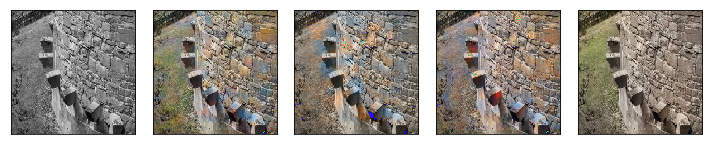

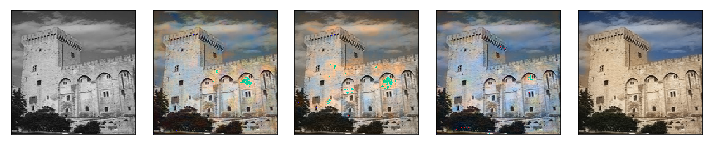

In [26]:
# Testing on certain images across all models
# Load models
color_model = load_model('../models-pascal/45-10.60.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})
color_resnet_model = load_model('../models2-pascal/res-65-10.94.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})
color_seg_model = load_model('../models-seg/57-7.93.hdf5', custom_objects={'euclidean_distance_1': euclidean_distance_1})
num_samples = X_train.shape[0]
start = 110
# eval_train_list = np.random.permutation(num_samples)[start : start + 5]
eval_train_list = np.arange(num_samples)[start:start + 2]

X_eval = X_train[eval_train_list]
Y_eval = Y_train[eval_train_list]

color_predict_img, resnet_predict_img, seg_predict_img = predict_img_all_models(
    X_eval, color_model, color_resnet_model, color_seg_model)
plot_img_all_models([color_predict_img, resnet_predict_img, seg_predict_img], Y_eval, X_eval)

In [8]:
pic_file

['beach-00.png',
 'beach-01.png',
 'beach-02.png',
 'beach-03.png',
 'beach-04.png',
 'beach-05.png',
 'beach-06.png',
 'beach-07.png',
 'beach-08.png',
 'beach-09.png',
 'beach-10.png',
 'beach-11.png',
 'beach-12.png',
 'beach-13.png',
 'beach-14.png',
 'beach-15.png',
 'beach-16.png',
 'beach-17.png',
 'beach-18.png',
 'beach-19.png',
 'beach-20.png',
 'beach-21.png',
 'beach-22.png',
 'beach-23.png',
 'beach-24.png',
 'beach-25.png',
 'beach-26.png',
 'beach-27.png',
 'beach-28.png',
 'beach-29.png',
 'beach-30.png',
 'beach-31.png',
 'beach-32.png',
 'beach-33.png',
 'beach-34.png',
 'beach-35.png',
 'beach-36.png',
 'beach-37.png',
 'beach-38.png',
 'beach-39.png',
 'bedroom-00.png',
 'bedroom-01.png',
 'bedroom-02.png',
 'bedroom-03.png',
 'bedroom-04.png',
 'bedroom-05.png',
 'bedroom-06.png',
 'bedroom-07.png',
 'bedroom-08.png',
 'bedroom-09.png',
 'bedroom-10.png',
 'bedroom-11.png',
 'bedroom-12.png',
 'bedroom-13.png',
 'bedroom-14.png',
 'bedroom-15.png',
 'bedroom-16.png